# Lesson 8: Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/master/notebooks/08_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- More Bayesian analysis examples
- Real-world data analysis in teams
- Intro to cognitive models


## The Mind as a Black Box

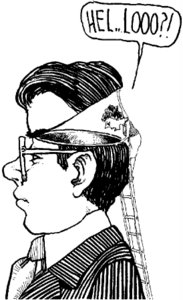

- Stuff comes in, behaviors come out...
- But what's going on in the box?

## Decisions as an important and accessible cognitive process

- Although we could try and open the box for all sorts of cognitive behaviors (e.g., perception, memory, etc...), decision making is a pervasive aspect of our lives.

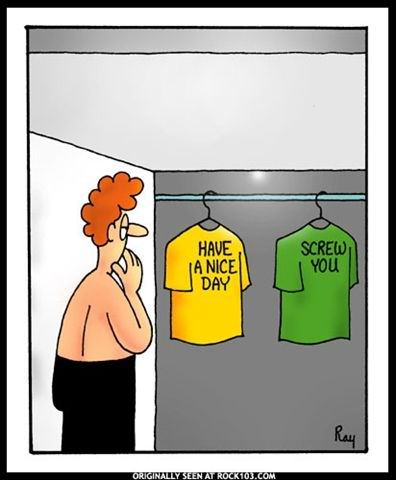

- What are some examples of decisions we make?


## How do we study decisions?

- What food would you rather eat?
- What direction are these dots moving?

## Questions we ask about decisions

- What choice did you make?
- How quickly did you make it?

## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

In [2]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats



## Load and process the data

In [23]:
# load in the data
dat = pd.read_csv('data/data_young_sub3.txt',
                  header=None,
                  names=['correct','rt','cond'], 
                  delimiter=' ')
dat.correct = dat.correct-1
dat['log_rt'] = np.log(dat['rt'])
dat.head()

,correct,rt,cond,log_rt
0,1,0.4553,NE,-0.786799
1,1,0.5210,NE,-0.652005
2,1,0.4512,NE,-0.795845
3,1,0.4784,AK,-0.737308
4,1,0.4300,AK,-0.843970


In [25]:
# show overall mean log_rt for each condition
dat.groupby(['cond'])['log_rt','correct'].mean()

,log_rt,correct
cond,,
AK,-0.552049,0.880109
NE,-0.639893,0.892537
SN,-1.017115,0.657068


In [18]:
print('Overall mean:', df.log_rt.mean())
print('Overall std:', df.log_rt.std())

Overall mean: 0.4093801030334287
Overall std: 0.3798122203107784


## What is a computational model? 

- Take processes and instantiate them within a set of equations and explicit rules for how they interact.

## Linear Ballistic Accumlator (LBA)

<img src="figs/lba.png">
